In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas_datareader.data as pdr
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
from datetime import datetime


from datetime import datetime

plt.style.use('bmh') #Bayesian Methods for Hackers style
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# stock_code = ['NKE', 'TSLA', 'AMD', 'IMGN', 'F', 
#               'UBER', 'INTC', 'NVDA', 'META', 'CS']

stock_code = ['UBER']

UBER
[*********************100%***********************]  1 of 1 completed
Epoch 1/100
30/30 [==============================] - 24s 261ms/step - loss: 0.0392
Epoch 2/100
30/30 [==============================] - 9s 287ms/step - loss: 0.0118
Epoch 3/100
30/30 [==============================] - 4s 122ms/step - loss: 0.0107
Epoch 4/100
30/30 [==============================] - 4s 142ms/step - loss: 0.0092
Epoch 5/100
30/30 [==============================] - 5s 161ms/step - loss: 0.0087
Epoch 6/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0081
Epoch 7/100
30/30 [==============================] - 4s 120ms/step - loss: 0.0082
Epoch 8/100
30/30 [==============================] - 5s 180ms/step - loss: 0.0067
Epoch 9/100
30/30 [==============================] - 4s 119ms/step - loss: 0.0064
Epoch 10/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0065
Epoch 11/100
30/30 [==============================] - 4s 134ms/step - loss: 0.0085
Epoch 12/100
30/30 [=

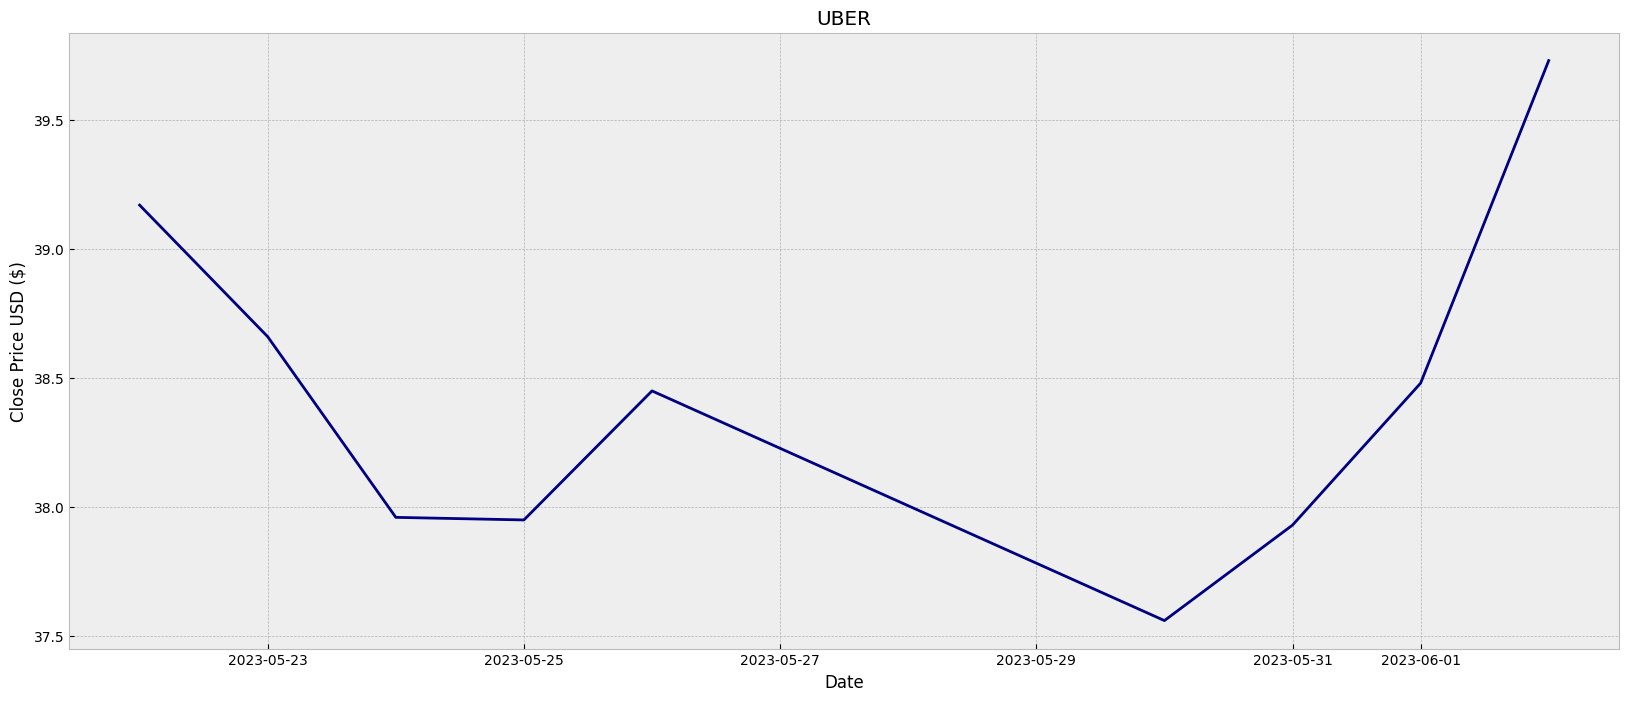

In [ ]:
#Load data
yf.pdr_override()


for i in stock_code:
  start_date = '01-05-2000' #Bắt đầu từ thứ 2
  end_date = '20-05-2023'   #Kết thúc vào thứ 6

  company = i
  print(company)

  start = datetime.strptime(start_date, '%d-%m-%Y')
  end = datetime.strptime(end_date, '%d-%m-%Y')
  df = pdr.get_data_yahoo(company, start=start, end=end)

  df.round(2)

  #Create a new dataframe with only the 'Close'
  data = df.filter(['Close'])
  data

  #Prepare data
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
  len(scaled_data)

  #Create x_train, y_train
  prediction_days = 60
  x_train = []
  y_train = []
  for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)

  #Reshape x_train
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  x_train.shape

  #Build the LSTM Model
  model = keras.Sequential()
  #RNN:
  model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))
  # Adding the output layer
  model.add(Dense(units = 1))
  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  # Fitting the RNN to the Training set
  model.fit(x_train, y_train, epochs = 100, batch_size = 32)
  model.save('/content/driver/My Drive/Colab/models/stock_' + company + '.h5')
  #Load the test data
  yf.pdr_override()

  start_date = '20-05-2023'

  currentDay = datetime.now().day
  currentMonth = datetime.now().month
  currentYear = datetime.now().year
  end_date = str(currentDay) + '-' + str(currentMonth) + '-' + str(currentYear)

  start = datetime.strptime(start_date, '%d-%m-%Y')
  end = datetime.strptime(end_date, '%d-%m-%Y')
  test_data = pdr.get_data_yahoo(company, start=start, end=end)

  actual_prices = test_data['Close'].values
  total_dataset = pd.concat((data['Close'],test_data['Close']), axis = 0)
  inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
  inputs = inputs.reshape(-1,1)
  inputs = scaler.transform(inputs)

  #Visualize the test data
  plt.figure(figsize=(20,8))
  plt.title(company)
  plt.xlabel('Date')
  plt.ylabel('Close Price USD ($)')
  plt.plot(test_data['Close'], color='navy')
  plt.show()

In [ ]:
#Create a new dataframe with only the 'Close'
data = df.filter(['Close'])
data

,Close
Date,
2019-05-10,41.570000
2019-05-13,37.099998
2019-05-14,39.959999
2019-05-15,41.290001
2019-05-16,43.000000
...,...
2023-05-15,38.139999
2023-05-16,37.439999
2023-05-17,37.840000


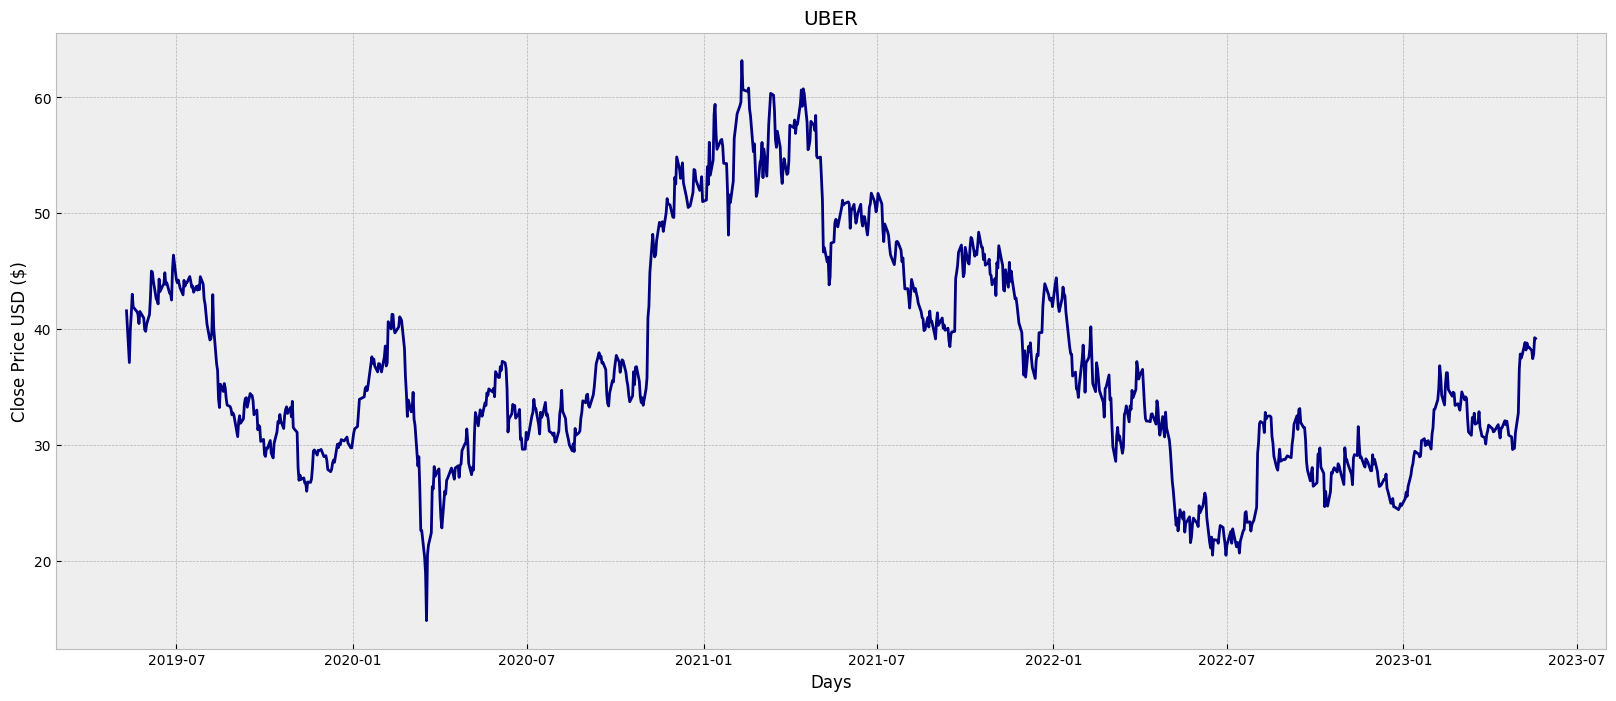

In [ ]:
#Visualize the close price data
plt.figure(figsize=(20,8))
plt.title(company)
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(data['Close'], color='navy')
plt.show()
#Timeseries: RNN
#Impor: Preprocessdata->learn pattern
#World predict changes not value

In [ ]:
#Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
len(scaled_data)

1015

In [ ]:
#Create x_train, y_train
prediction_days = 60
x_train = []
y_train = []
for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape x_train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(955, 60, 1)

In [ ]:
#Build the LSTM Model
model = keras.Sequential()
#RNN:
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 100, batch_size = 32)
model.save('/content/driver/My Drive/Colab/models/stock_' + company + '.h5')

Epoch 1/100
30/30 [==============================] - 12s 132ms/step - loss: 0.0421
Epoch 2/100
30/30 [==============================] - 5s 172ms/step - loss: 0.0106
Epoch 3/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0093
Epoch 4/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0085
Epoch 5/100
30/30 [==============================] - 5s 170ms/step - loss: 0.0081
Epoch 6/100
30/30 [==============================] - 4s 134ms/step - loss: 0.0085
Epoch 7/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0084
Epoch 8/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0070
Epoch 9/100
30/30 [==============================] - 6s 183ms/step - loss: 0.0075
Epoch 10/100
30/30 [==============================] - 4s 117ms/step - loss: 0.0071
Epoch 11/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0070
Epoch 12/100
30/30 [==============================] - 5s 153ms/step - loss: 0.0064
Epoch 13/100

[*********************100%***********************]  1 of 1 completed


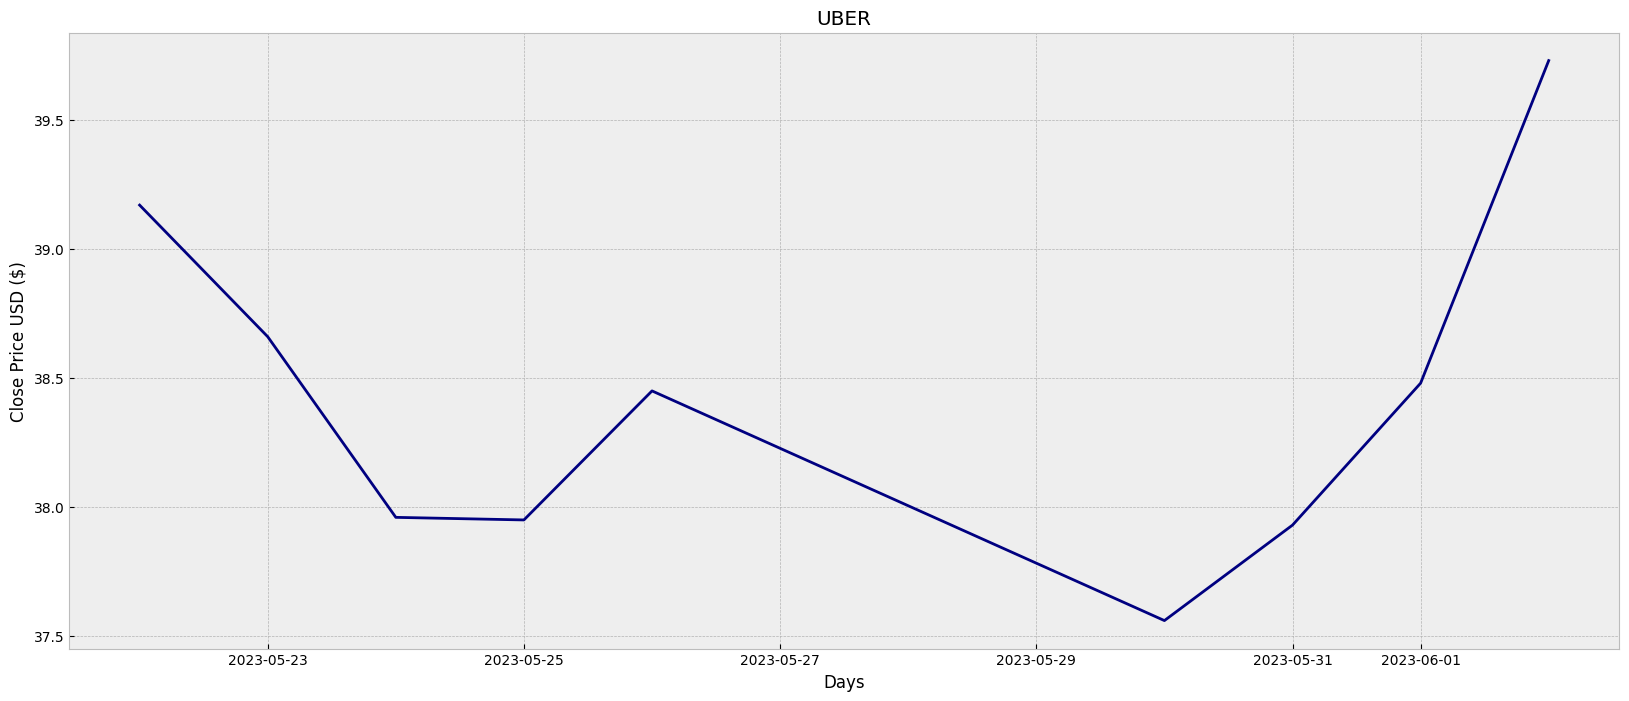

In [ ]:
#Load the test data
yf.pdr_override()

start_date = '20-05-2023'

currentDay = datetime.now().day
currentMonth = datetime.now().month
currentYear = datetime.now().year
end_date = str(currentDay) + '-' + str(currentMonth) + '-' + str(currentYear)

start = datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.strptime(end_date, '%d-%m-%Y')
test_data = pdr.get_data_yahoo(company, start=start, end=end)

actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'],test_data['Close']), axis = 0)
inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

#Visualize the test data
plt.figure(figsize=(20,8))
plt.title(company)
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(test_data['Close'],color='navy')
plt.show()

In [ ]:
#Prediction on test data
x_test = []
for x in range(prediction_days, len(inputs)):
  x_test.append(inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = keras.models.load_model('/content/driver/My Drive/Colab/models/stock_' + company + '.h5')
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

1/1 [==============================] - 2s 2s/step


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

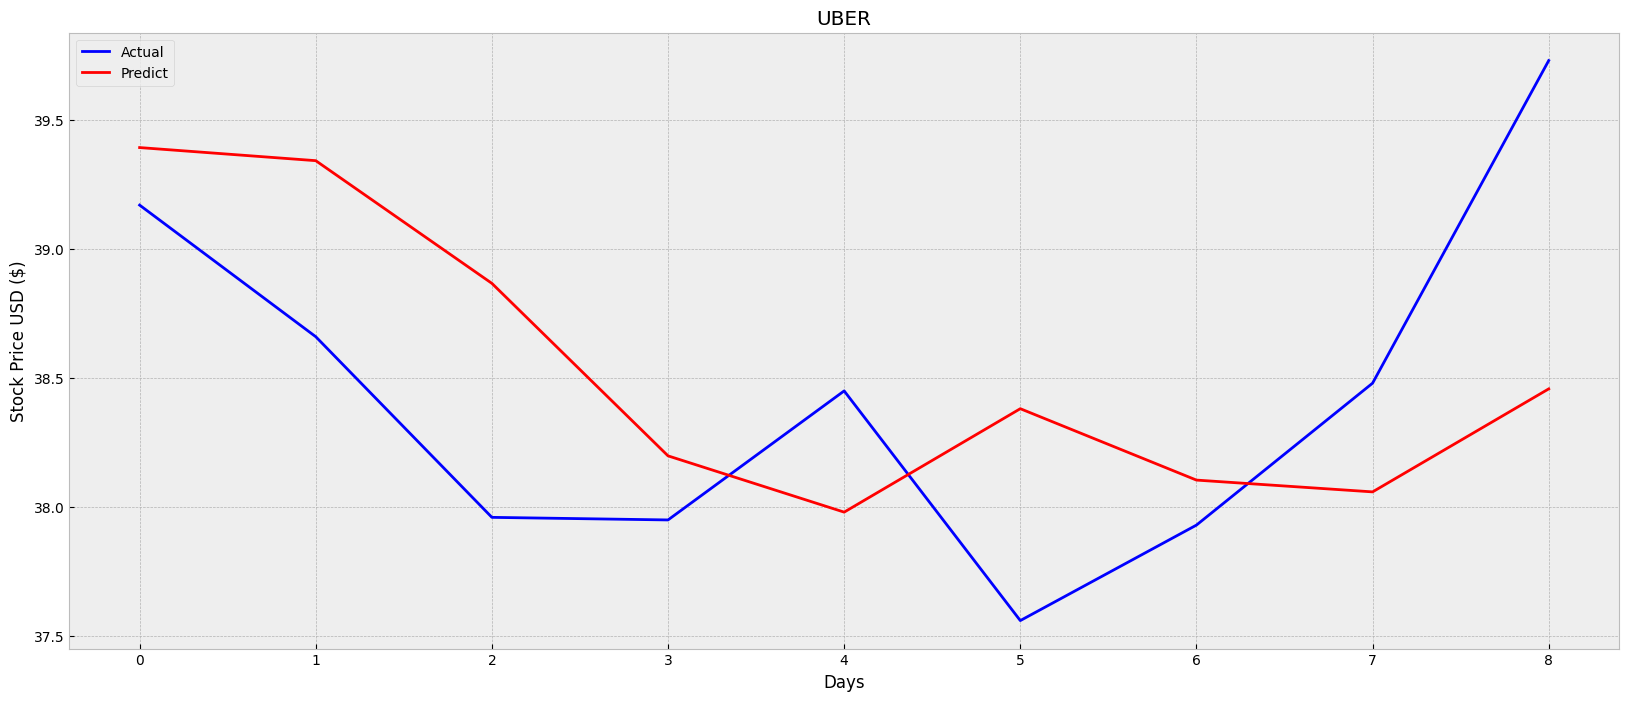

In [ ]:
#visualize the data
plt.figure(figsize=(20,8))
plt.title(company)
plt.xlabel('Days')
plt.ylabel('Stock Price USD ($)')
plt.plot(actual_prices, color="blue")
plt.plot(predicted_prices, color="red")
plt.legend(['Actual', 'Predict'])
plt.show()

In [ ]:
#Predict the next day
real_data = [inputs[len(inputs) + 1 - prediction_days:len(inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)

aa=float((prediction-inputs[-1])*100)

prediction = scaler.inverse_transform(prediction)
print(f"Prediction of the next day: {prediction}")

1/1 [==============================] - 2s 2s/step
Prediction of the next day: [[39.461517]]


1/1 [==============================] - 0s 22ms/step


2023-06-05 13:15:26.083 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py [ARGUMENTS]


<function matplotlib.pyplot.show(close=None, block=None)>

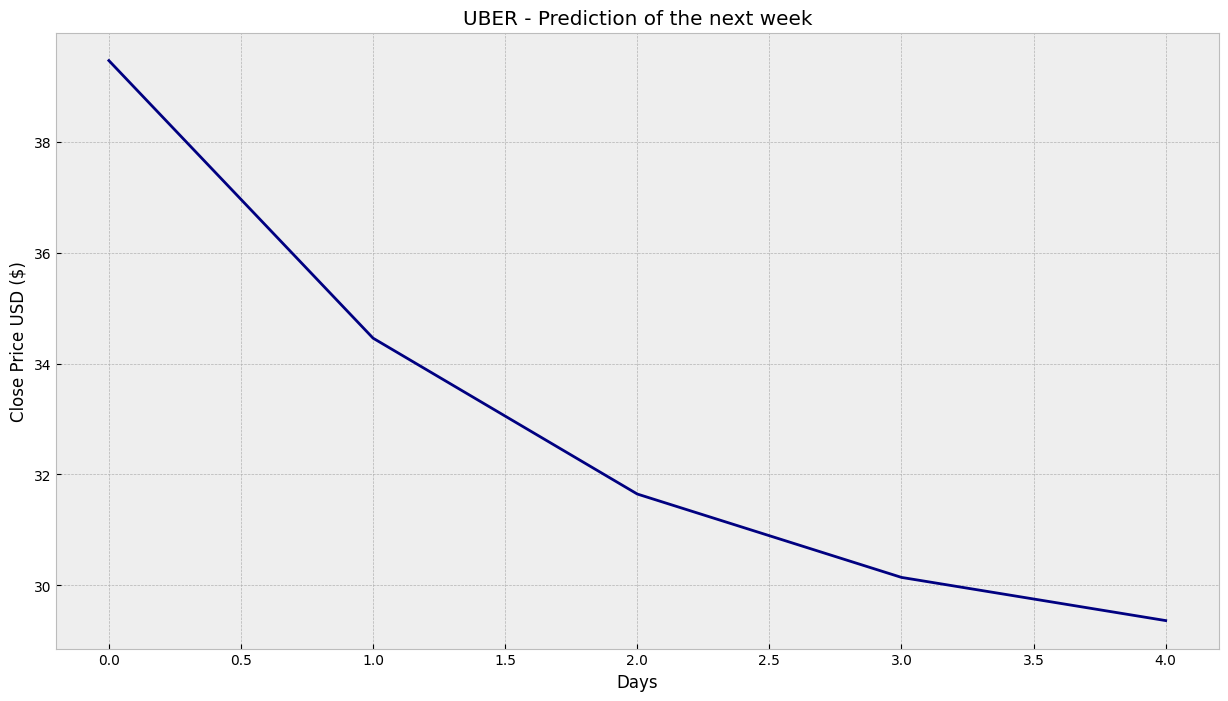

In [ ]:
#Predict the next week
week = []
for i in range(5):
  real_data = [inputs[len(inputs) + 1 - prediction_days:len(inputs+1),0]]
  if i > 0:
      real_data.append(prediction)
      real_data.pop(0)

  real_data = np.array(real_data)
  real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

  prediction = model.predict(real_data)
  week.append(prediction)
  

for i in range(5):
  week[i] = scaler.inverse_transform(week[i])

#Visualize the data
aa=float((prediction-inputs[-1])*100)
week = np.array(week).reshape(-1,1)
week = week.flatten()
st.title(f"Prediction of the next week's price")

plt.figure(figsize=(15,8))
plt.title(company + ' - Prediction of the next week')
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(week, color='navy')
plt.show